In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Regression model

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



from sklearn.ensemble import VotingRegressor, StackingRegressor


#metrices

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv("bangladesh_student_performance.csv")
df

,date,gender,age,address,famsize,Pstatus,M_Edu,F_Edu,M_Job,F_Job,relationship,smoker,tuition_fee,time_friends,ssc_result,hsc_result
0,29/04/2018,M,18,Rural,GT3,Together,3,2,At_home,Farmer,No,No,71672,4,4.22,3.72
1,29/04/2018,F,19,Rural,LE3,Apart,0,4,Other,Health,Yes,No,26085,5,3.47,2.62
2,29/04/2018,F,19,Rural,GT3,Together,0,3,Teacher,Services,No,No,40891,3,3.32,2.56
3,29/04/2018,F,19,Rural,LE3,Apart,2,3,At_home,Business,No,No,50600,2,4.57,4.17
4,29/04/2018,M,17,Rural,GT3,Together,1,1,At_home,Farmer,No,No,62458,2,4.50,3.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,29/04/2018,M,18,Urban,GT3,Together,2,2,Teacher,Health,No,No,108426,2,3.57,3.18
2014,29/04/2018,M,19,Urban,GT3,Together,0,3,Other,Teacher,Yes,No,100665,5,4.05,3.13
2015,29/04/2018,M,18,Urban,GT3,Together,3,2,Services,Farmer,Yes,No,92291,1,3.93,3.15
2016,29/04/2018,M,19,Rural,GT3,Together,0,2,At_home,Teacher,No,No,43926,3,3.34,2.83


Yadata profilint

In [14]:
from ydata_profiling import ProfileReport

profile = ProfileReport( df , title="Bangladesh Student performance prediction", explorative = True  )

profile.to_file("ydata.html")

ModuleNotFoundError: No module named 'ydata_profiling'

In [ ]:
print(len(df.columns))
print(len(df))


16
2018


In [ ]:
df.columns= [
    'date','st_gender','st_age','st_address',
    'st_fam_size','pstatus','m_edu','f_edu',
    'm_job','f_job','st_relationship',
    'smoker','tuition_fee','time_with_friends',
    'ssc_result','hsc_result'
]
df.columns.size

16

In [ ]:
df.shape

(2018, 16)

drop data

In [ ]:
# df.drop(columns=['date'], inplace=True)

if 'date' in df.columns:
   df.drop(columns=['date'], inplace=True) 

In [ ]:
df.columns.size

15

Correlatin for Numerical Value

In [ ]:
corr_target = df.select_dtypes(include=np.number).corr()['hsc_result'].sort_values(ascending=False)
print(corr_target)

hsc_result           1.000000
ssc_result           0.950178
m_edu                0.063776
f_edu                0.054811
tuition_fee          0.038068
st_age              -0.009857
time_with_friends   -0.156356
Name: hsc_result, dtype: float64


X and Y seperate

In [29]:
X = df.drop('hsc_result', axis=1)
Y = df['hsc_result']


#Numerical Column and Categorical Columns

In [30]:
numeric_features = X.select_dtypes(include = ['int64','float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

print(numeric_features)
print(categorical_features)

Index(['age', 'M_Edu', 'F_Edu', 'tuition_fee', 'time_friends', 'ssc_result'], dtype='object')
Index(['date', 'gender', 'address', 'famsize', 'Pstatus', 'M_Job', 'F_Job',
       'relationship', 'smoker'],
      dtype='object')


#pipeline

In [31]:
#for numerical features

num_transformer = Pipeline (
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# For categorical feature

In [32]:
cat_transformer = Pipeline( steps = [
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
] )

In [33]:
#combine them
preprocessor = ColumnTransformer(
    transformers= [
        ('num',num_transformer,numeric_features),
        ('cat',cat_transformer,categorical_features)
    ]
    )

##Split

In [35]:
X_train,X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2 , random_state=42)

# Ensemble - boosting, stacking

In [17]:
# base learner
reg_lr = LinearRegression()
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [18]:
# voting regressor

voting_reg = VotingRegressor(
    estimators=[
        ('lr', reg_lr),
        ('rf',reg_rf),
        ('gb', reg_gb)
    ]
)

In [19]:
# stacking

stacking_reg = StackingRegressor(
    estimators=[
        ('rf',reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator=Ridge() ## the meta learner
)

##Model training

In [20]:
#dictionary for all model

model_to_train ={
    'Linear Regression' : reg_lr,
    'Random Forest' : reg_rf,
    'Gradient Boosting': reg_gb,
    'Voting Ensemble ' : voting_reg,
    'Stacking Ensemble ' : stacking_reg
}

In [36]:
#training & Evaluation

result = []

for name , model in model_to_train.items():
  #create full pipeline with preprocessor
  pipe = Pipeline(
      [
          ('preprocessor', preprocessor),
          ('model',model)
      ]
  )

  #train

  pipe.fit(X_train,y_train)

  #predict

  y_pred = pipe.predict(X_test)

  #Evaluate

  r2 = r2_score(y_test,y_pred)
  rmse = np.sqrt(mean_squared_error(y_test,y_pred))
  mae = mean_absolute_error(y_test,y_pred)

  result.append({
      "Model": name,
      "R2 Score" :r2,
      "RMSE": rmse,
      "MAE" : mae
  })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)

print(results_df)

                Model  R2 Score      RMSE       MAE
4  Stacking Ensemble   0.959593  0.123064  0.098701
2   Gradient Boosting  0.959565  0.123107  0.098902
3    Voting Ensemble   0.957566  0.126113  0.100854
1       Random Forest  0.950456  0.136269  0.108434
0   Linear Regression  0.945920  0.142371  0.111376


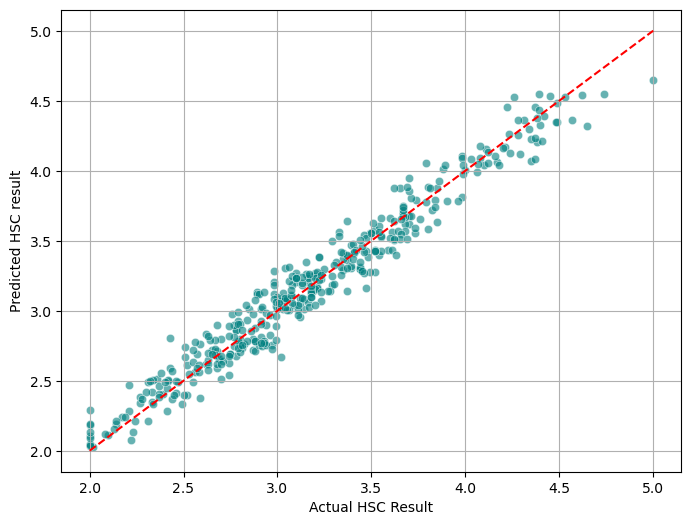

In [40]:
# Visualization

best_model_name = results_df.iloc[0]['Model']
best_model_obj = model_to_train[best_model_name]

# fit the best model
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model',best_model_obj)
])

final_pipe.fit(X_train,y_train)
y_final_pred = final_pipe.predict(X_test)

#plot Actual vs predicted

plt.figure( figsize = (8,6) )

sns.scatterplot(x=y_test, y=y_final_pred, alpha = 0.6, color='teal' )
plt.plot( [2,5] , [2,5], color = "red", linestyle = '--'  )

plt.xlabel("Actual HSC Result")
plt.ylabel("Predicted HSC result")

plt.grid(True)
plt.show()